In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import lightgbm as lgb
import optuna
# Suppress Optuna logs for cleaner output
optuna.logging.set_verbosity(optuna.logging.WARNING)

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, classification_report

from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold

In [18]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
import numpy as np

def load_and_preprocess_data(file_path, is_train=True):
    """
    Load and preprocess the spaceship titanic data
    
    Args:
        file_path: Path to the CSV file
        is_train: Boolean indicating if this is training data (has 'Transported' column)
    
    Returns:
        Preprocessed dataframe
    """
    df = pd.read_csv(file_path)
    
    # Define categorical features
    categorical_features = ['HomePlanet', 'VIP', 'CryoSleep', 'Destination', 'Cabin', 'Name']
    
    # Handle missing values
    df = handle_missing_values(df, categorical_features)
    
    # Create new features
    df = create_features(df)
    
    # Convert to appropriate data types
    df = convert_data_types(df)
    
    return df

def handle_missing_values(df, categorical_features):
    """Handle missing values for numerical and categorical features"""
    df = df.copy()
    
    # Impute Age with mean
    age_imputer = SimpleImputer()
    df['Age'] = age_imputer.fit_transform(df[['Age']]).flatten()
    
    # Impute spending columns with most frequent value
    spending_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
    spent_imputer = SimpleImputer(strategy='most_frequent')
    df[spending_cols] = spent_imputer.fit_transform(df[spending_cols])
    
    # Fill categorical missing values with 'Missing'
    for col in categorical_features:
        df[col] = df[col].fillna('Missing')
    
    return df

def create_features(df):
    """Create engineered features"""
    df = df.copy()
    
    # Solo traveler feature
    df['SoloTraveler'] = (df['Cabin'].map(df['Cabin'].value_counts()) == 1)
    
    # Spending features
    spending_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
    df['TotalSpend'] = df[spending_cols].sum(axis=1)
    df['LuxurySpend'] = df[['Spa', 'VRDeck']].sum(axis=1)
    df['BasicSpend'] = df[['RoomService', 'FoodCourt']].sum(axis=1)
    
    # Cabin-based interaction features
    cabin_prefix = df['Cabin'].astype(str).str.split('/').str[0]
    df['Cabin_HomePlanet'] = cabin_prefix + "_" + df['HomePlanet'].astype(str)
    df['Cabin_Destination'] = cabin_prefix + "_" + df['Destination'].astype(str)
    df['Cabin_CryoSleep'] = cabin_prefix + "_" + df['CryoSleep'].astype(str)
    
    return df

def convert_data_types(df):
    """Convert columns to appropriate data types"""
    df = df.copy()
    
    # Convert to categorical
    categorical_cols = ['HomePlanet', 'Destination', 'VIP', 'CryoSleep', 'SoloTraveler',
                       'Cabin_HomePlanet', 'Cabin_Destination', 'Cabin_CryoSleep']
    
    for col in categorical_cols:
        if col in df.columns:
            df[col] = df[col].astype('category')
    
    return df

def select_features_and_prepare_target(df, features_to_drop=None, is_train=True):
    """
    Select features and prepare target variable
    
    Args:
        df: Preprocessed dataframe
        features_to_drop: List of additional features to drop
        is_train: Boolean indicating if this is training data
    
    Returns:
        X (features), y (target if train data), feature_names, categorical_features
    """
    df = df.copy()
    
    # Default features to drop
    default_drop = [
        'PassengerId', 'Cabin', 'Name'
    ]
    
    if features_to_drop:
        default_drop.extend(features_to_drop)
    
    # Remove target variable from features if it exists
    if is_train and 'Transported' in df.columns:
        y = df['Transported']
        default_drop.append('Transported')
    else:
        y = None
    
    # Select features
    X = df.drop(default_drop, axis=1, errors='ignore')
    
    # Get categorical feature names
    categorical_features = X.select_dtypes(include='category').columns.tolist()
    
    return X, y, X.columns.tolist(), categorical_features

def encode_categorical_features(X, categorical_features, encoders=None, fit=True):
    """
    Encode categorical features using LabelEncoder
    
    Args:
        X: Feature dataframe
        categorical_features: List of categorical feature names
        encoders: Dictionary of fitted encoders (for test data)
        fit: Whether to fit new encoders (True for train, False for test)
    
    Returns:
        X_encoded, encoders_dict
    """
    X_encoded = X.copy()
    
    if encoders is None:
        encoders = {}
    
    for col in categorical_features:
        if col in X_encoded.columns:
            X_encoded[col] = X_encoded[col].astype(str)
            
            if fit:
                # Fit new encoder for training data
                le = LabelEncoder()
                X_encoded[col] = le.fit_transform(X_encoded[col])
                encoders[col] = le
            else:
                # Use existing encoder for test data
                if col in encoders:
                    # Handle unseen categories
                    le = encoders[col]
                    mask = X_encoded[col].isin(le.classes_)
                    X_encoded.loc[mask, col] = le.transform(X_encoded.loc[mask, col])
                    X_encoded.loc[~mask, col] = -1  # Assign -1 to unseen categories
                    
                    # Explicitly convert to int64 to match training data
                    X_encoded[col] = X_encoded[col].astype('int64')
                else:
                    # If no encoder exists, assign -1 to all values
                    X_encoded[col] = -1
                    X_encoded[col] = X_encoded[col].astype('int64')
    
    # Ensure all categorical features are properly converted to int64
    for col in categorical_features:
        if col in X_encoded.columns:
            X_encoded[col] = pd.to_numeric(X_encoded[col], errors='coerce').fillna(-1).astype('int64')
    
    return X_encoded, encoders

# Main pipeline function
def prepare_data(train_path, test_path=None, additional_drops=None):
    """
    Complete pipeline to prepare train and test data
    
    Args:
        train_path: Path to training data
        test_path: Path to test data (optional)
        additional_drops: Additional features to drop
    
    Returns:
        Dictionary containing processed data and encoders
    """
    # Process training data
    print("Processing training data...")
    train_df = load_and_preprocess_data(train_path, is_train=True)
    X_train, y_train, feature_names, cat_features = select_features_and_prepare_target(
        train_df, additional_drops, is_train=True
    )
    X_train_encoded, encoders = encode_categorical_features(
        X_train, cat_features, fit=True
    )
    
    print(f"Training data shape: {X_train_encoded.shape}")
    print(f"Features: {feature_names}")
    print(f"Categorical features: {cat_features}")
    
    result = {
        'X_train': X_train_encoded,
        'y_train': y_train,
        'feature_names': feature_names,
        'categorical_features': cat_features,
        'encoders': encoders
    }
    
    # Process test data if provided
    if test_path:
        print("\nProcessing test data...")
        test_df = load_and_preprocess_data(test_path, is_train=False)
        X_test, _, _, _ = select_features_and_prepare_target(
            test_df, additional_drops, is_train=False
        )
        X_test_encoded, _ = encode_categorical_features(
            X_test, cat_features, encoders=encoders, fit=False
        )
        
        print(f"Test data shape: {X_test_encoded.shape}")
        
        result['X_test'] = X_test_encoded
    
    return result

# Example usage:
if __name__ == "__main__":
    # Data URLs
    train_url = "https://raw.githubusercontent.com/stepthom/869_course/refs/heads/main/data/spaceship_titanic_train.csv"
    test_url = "https://raw.githubusercontent.com/stepthom/869_course/refs/heads/main/data/spaceship_titanic_test.csv"
    X_Passenger_ID = pd.read_csv(test_url)
    
    # You can specify additional features to drop
    additional_features_to_drop = []  # Add any additional features you want to drop
    
    # Process both training and test data
    data = prepare_data(train_url, test_path=test_url, additional_drops=additional_features_to_drop)
    
    # Access the results
    X_train = data['X_train']
    y_train = data['y_train']
    X_test = data['X_test']
    passenger_ids = X_Passenger_ID["PassengerId"]
    feature_names = data['feature_names']
    categorical_features = data['categorical_features']
    
    print(f"\nFinal training data info:")
    print(X_train.info())
    print(f"\nFinal test data info:")
    print(X_test.info())
    print(f"\nTarget distribution:")
    print(y_train.value_counts())
    print(f"\nFeature consistency check:")
    print(f"Training features: {X_train.shape[1]}")
    print(f"Test features: {X_test.shape[1]}")
    print(f"Feature names match: {list(X_train.columns) == list(X_test.columns)}")
    
    # Additional dtype consistency check
    print(f"\nDtype consistency check:")
    for col in X_train.columns:
        train_dtype = X_train[col].dtype
        test_dtype = X_test[col].dtype
        match = train_dtype == test_dtype
        print(f"{col}: Train({train_dtype}) vs Test({test_dtype}) - Match: {match}")
        if not match:
            print(f"  ⚠️  Dtype mismatch detected!")

Processing training data...
Training data shape: (8693, 17)
Features: ['HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'SoloTraveler', 'TotalSpend', 'LuxurySpend', 'BasicSpend', 'Cabin_HomePlanet', 'Cabin_Destination', 'Cabin_CryoSleep']
Categorical features: ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'SoloTraveler', 'Cabin_HomePlanet', 'Cabin_Destination', 'Cabin_CryoSleep']

Processing test data...
Test data shape: (4277, 17)

Final training data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   HomePlanet         8693 non-null   int64  
 1   CryoSleep          8693 non-null   int64  
 2   Destination        8693 non-null   int64  
 3   Age                8693 non-null   float64
 4   VIP                8693 non-null   int64  
 5   RoomService      

In [19]:
# ============================================================================
# SEGMENT 2: Baseline XGBoost Model
# ============================================================================

def evaluate_model(X, y, model_params=None, cv_folds=5):
    """Evaluate XGBoost model using cross-validation F1 score"""
    if model_params is None:
        model_params = {
            'objective': 'binary:logistic',
            'eval_metric': 'logloss',
            'random_state': 42,
            'n_jobs': -1
        }
    
    model = XGBClassifier(**model_params)
    
    # Stratified K-Fold for better evaluation
    skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)
    f1_scores = cross_val_score(model, X, y, cv=skf, scoring='f1')
    
    return f1_scores.mean(), f1_scores.std()

# Baseline model parameters
baseline_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'random_state': 42,
    'n_jobs': -1,
    'n_estimators': 100
}

print("\n" + "="*50)
print("BASELINE MODEL EVALUATION")
print("="*50)

baseline_f1, baseline_std = evaluate_model(X_train, y_train, baseline_params)
print(f"Baseline F1 Score: {baseline_f1:.4f} (+/- {baseline_std:.4f})")


BASELINE MODEL EVALUATION
Baseline F1 Score: 0.8003 (+/- 0.0051)


In [20]:
# ============================================================================
# SEGMENT 3: Feature Importance Analysis and Selection
# ============================================================================

def get_feature_importance(X, y, model_params):
    """Get feature importance from XGBoost model"""
    model = XGBClassifier(**model_params)
    model.fit(X, y)
    
    # Get feature importance
    importance_df = pd.DataFrame({
        'feature': X.columns,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    return importance_df, model

print("\n" + "="*50)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*50)

# Get initial feature importance
importance_df, baseline_model = get_feature_importance(X_train, y_train, baseline_params)
print("Top 10 Most Important Features:")
print(importance_df.head(10))


FEATURE IMPORTANCE ANALYSIS
Top 10 Most Important Features:
              feature  importance
0          HomePlanet    0.261189
11         TotalSpend    0.168515
1           CryoSleep    0.088575
12        LuxurySpend    0.069257
6           FoodCourt    0.056920
14   Cabin_HomePlanet    0.054384
5         RoomService    0.050882
15  Cabin_Destination    0.037255
7        ShoppingMall    0.036211
16    Cabin_CryoSleep    0.032474



RECURSIVE FEATURE ELIMINATION

Starting with 17 features
Performing recursive feature elimination...
Features: 17, F1: 0.8003 (+/- 0.0051)
Features: 16, F1: 0.8001 (+/- 0.0058), Removed: SoloTraveler
Features: 15, F1: 0.8043 (+/- 0.0096), Removed: VIP
Features: 14, F1: 0.7970 (+/- 0.0097), Removed: Spa
Features: 13, F1: 0.8028 (+/- 0.0035), Removed: BasicSpend
Features: 12, F1: 0.7970 (+/- 0.0061), Removed: VRDeck
Features: 11, F1: 0.7987 (+/- 0.0063), Removed: Destination
Features: 10, F1: 0.8008 (+/- 0.0082), Removed: Age
Features: 9, F1: 0.7993 (+/- 0.0083), Removed: Cabin_CryoSleep
Features: 8, F1: 0.8013 (+/- 0.0090), Removed: Cabin_Destination
Features: 7, F1: 0.8020 (+/- 0.0052), Removed: ShoppingMall
Features: 6, F1: 0.8054 (+/- 0.0081), Removed: FoodCourt
Features: 5, F1: 0.7970 (+/- 0.0055), Removed: Cabin_HomePlanet
Features: 4, F1: 0.7194 (+/- 0.0077), Removed: LuxurySpend
Features: 3, F1: 0.7173 (+/- 0.0069), Removed: RoomService

Best F1 Score: 0.8054
Optimal number of f

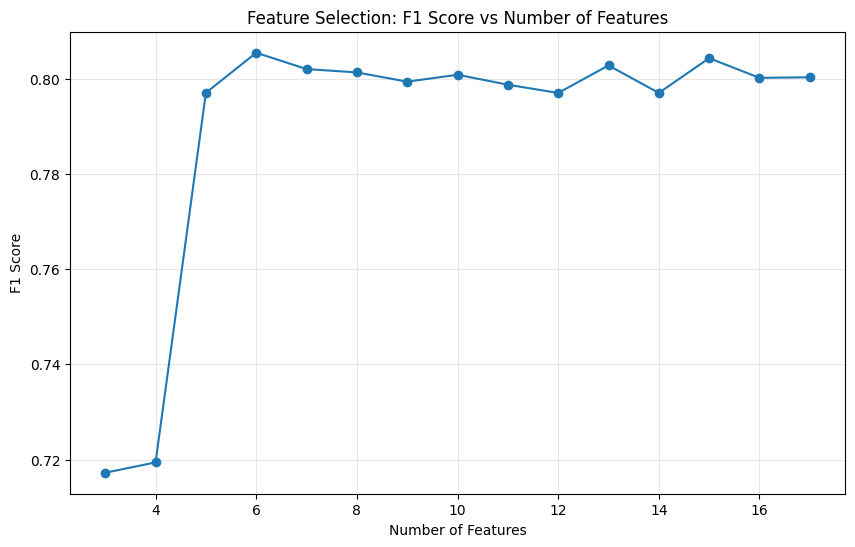

In [21]:
# ============================================================================
# SEGMENT 4: Recursive Feature Elimination
# ============================================================================

def recursive_feature_elimination(X, y, model_params, min_features=5):
    """
    Perform recursive feature elimination by removing least important features one by one
    """
    current_features = X.columns.tolist()
    results = []
    
    print(f"\nStarting with {len(current_features)} features")
    print("Performing recursive feature elimination...")
    
    # Initial evaluation
    f1_score, f1_std = evaluate_model(X[current_features], y, model_params)
    results.append({
        'n_features': len(current_features),
        'f1_score': f1_score,
        'f1_std': f1_std,
        'removed_feature': None
    })
    print(f"Features: {len(current_features)}, F1: {f1_score:.4f} (+/- {f1_std:.4f})")
    
    best_f1 = f1_score
    best_features = current_features.copy()
    
    while len(current_features) > min_features:
        # Get feature importance for current features
        importance_df, _ = get_feature_importance(X[current_features], y, model_params)
        
        # Remove least important feature
        least_important = importance_df.iloc[-1]['feature']
        current_features.remove(least_important)
        
        # Evaluate with remaining features
        f1_score, f1_std = evaluate_model(X[current_features], y, model_params)
        
        results.append({
            'n_features': len(current_features),
            'f1_score': f1_score,
            'f1_std': f1_std,
            'removed_feature': least_important
        })
        
        print(f"Features: {len(current_features)}, F1: {f1_score:.4f} (+/- {f1_std:.4f}), Removed: {least_important}")
        
        # Track best performance
        if f1_score > best_f1:
            best_f1 = f1_score
            best_features = current_features.copy()
    
    return pd.DataFrame(results), best_features, best_f1

# Perform feature selection
print("\n" + "="*50)
print("RECURSIVE FEATURE ELIMINATION")
print("="*50)

feature_selection_results, best_features, best_f1_score = recursive_feature_elimination(
    X_train, y_train, baseline_params, min_features=3  # ADJUST THIS NUMBER
)

print(f"\nBest F1 Score: {best_f1_score:.4f}")
print(f"Optimal number of features: {len(best_features)}")
print(f"Selected features: {best_features}")

# Plot feature selection results
plt.figure(figsize=(10, 6))
plt.plot(feature_selection_results['n_features'], feature_selection_results['f1_score'], marker='o')
plt.xlabel('Number of Features')
plt.ylabel('F1 Score')
plt.title('Feature Selection: F1 Score vs Number of Features')
plt.grid(True, alpha=0.3)
plt.show()

In [22]:
# ============================================================================
# SEGMENT 4A: IDENTIFY HIGH-PERFORMING FEATURE COUNTS (F1 > 0.805)
# ============================================================================

print(f"\n" + "="*60)
print("IDENTIFYING HIGH-PERFORMING FEATURE COUNTS")
print("="*60)

# Find all feature counts with F1 > 0.805 from recursive elimination
threshold = 0.805
high_performing = feature_selection_results[feature_selection_results['f1_score'] > threshold].copy()
high_performing = high_performing.sort_values('f1_score', ascending=False)

print(f"Feature counts with F1 > {threshold}:")
print(high_performing[['n_features', 'f1_score']].to_string(index=False, float_format='%.4f'))

# Get the feature counts to optimize
feature_counts_to_optimize = high_performing['n_features'].tolist()
print(f"\nSelected for hyperparameter tuning: {feature_counts_to_optimize}")
print(f"Total models to optimize: {len(feature_counts_to_optimize)}")

def get_features_for_count(feature_selection_results, X_train_columns, target_count):
    """Get the exact feature list for a specific feature count from recursive elimination"""
    current_features = X_train_columns.tolist()
    
    # Remove features in the order they were removed during recursive elimination
    for _, row in feature_selection_results.iterrows():
        if row['n_features'] < len(current_features):
            removed_feature = row['removed_feature']
            if removed_feature in current_features:
                current_features.remove(removed_feature)
            
            # Stop when we reach target number of features
            if len(current_features) == target_count:
                break
    
    return current_features


IDENTIFYING HIGH-PERFORMING FEATURE COUNTS
Feature counts with F1 > 0.805:
 n_features  f1_score
          6    0.8054

Selected for hyperparameter tuning: [6]
Total models to optimize: 1


In [23]:
# ============================================================================
# SEGMENT 4B: HYPERPARAMETER TUNING FOR HIGH-PERFORMING FEATURE SETS
# ============================================================================

import functools  # for partial

def create_objective_function(X_features, y_target):
    """Create Optuna objective function for specific feature set"""
    def objective(trial):
        # Define hyperparameter search space
        params = {
            'objective': 'binary:logistic',
            'eval_metric': 'logloss',
            'random_state': 42,
            'n_jobs': -1,
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=50),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.8, log=True),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
            'gamma': trial.suggest_float('gamma', 0, 5),
            'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
            'reg_lambda': trial.suggest_float('reg_lambda', 1, 10)
        }
        
        # Evaluate model and return F1 score
        f1_mean, _ = evaluate_model(X_features, y_target, params, cv_folds=5)
        return f1_mean  # Optuna maximizes by default
    
    return objective

# Progress callback for Optuna — with parameter total_trials
def progress_callback(study, trial, total_trials):
    completed = len(study.trials)
    print(f"\r    Trials completed: {completed}/{total_trials}", end="")

print(f"\n" + "="*60)
print("HYPERPARAMETER TUNING FOR HIGH-PERFORMING FEATURE SETS")
print("="*60)

# Store results for all optimized feature sets
optimization_results = {}

for i, feature_count in enumerate(feature_counts_to_optimize, 1):
    print(f"\n[{i}/{len(feature_counts_to_optimize)}] Optimizing {feature_count} features...")
    
    # Get the exact features for this count
    current_features = get_features_for_count(feature_selection_results, X_train.columns, feature_count)
    baseline_f1 = feature_selection_results[feature_selection_results['n_features'] == feature_count]['f1_score'].iloc[0]
    
    print(f"  Baseline F1: {baseline_f1:.4f}")
    
    n_trials_to_run = 50  # ← You control here how many trials you want
    
    print(f"  Running {n_trials_to_run} optimization trials with Optuna...")
    
    # Create Optuna study
    study = optuna.create_study(
        direction='maximize',  # Maximize F1 score
        sampler=optuna.samplers.TPESampler(seed=42),  # Use TPE sampler
        pruner=optuna.pruners.MedianPruner()  # Prune bad trials early
    )
    
    # Create objective function for this specific feature set
    objective_func = create_objective_function(X_train[current_features], y_train)
    
    # Run optimization with progress callback (using partial)
    progress_cb = functools.partial(progress_callback, total_trials=n_trials_to_run)
    
    study.optimize(objective_func, n_trials=n_trials_to_run, show_progress_bar=False, callbacks=[progress_cb])
    
    print()  # move to next line after progress bar
    
    # Get best parameters
    best_params = study.best_params.copy()
    best_params.update({
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'random_state': 42,
        'n_jobs': -1
    })
    
    # Evaluate optimized model
    optimized_f1 = study.best_value
    
    # Get standard deviation by re-evaluating best params
    _, optimized_std = evaluate_model(X_train[current_features], y_train, best_params)
    
    improvement = optimized_f1 - baseline_f1
    
    print(f"  Optimized F1: {optimized_f1:.4f} (+/- {optimized_std:.4f})")
    print(f"  Improvement: +{improvement:.4f}")
    print(f"  Best trial: {study.best_trial.number}")
    
    # Store results
    optimization_results[feature_count] = {
        'features': current_features,
        'baseline_f1': baseline_f1,
        'optimized_f1': optimized_f1,
        'optimized_std': optimized_std,
        'improvement': improvement,
        'best_params': best_params,
        'study': study  # Store study for potential visualization
    }

# ============================================================================
# SEGMENT 4C: COMPARE ALL OPTIMIZED MODELS
# ============================================================================

print(f"\n" + "="*60)
print("OPTIMIZATION RESULTS COMPARISON")
print("="*60)

# Create comparison table
comparison_data = []
for feature_count, results in optimization_results.items():
    comparison_data.append({
        'Features': feature_count,
        'Baseline_F1': results['baseline_f1'],
        'Optimized_F1': results['optimized_f1'],
        'Improvement': results['improvement'],
        'Std_Dev': results['optimized_std'],
    })

comparison_df = pd.DataFrame(comparison_data).sort_values('Optimized_F1', ascending=False)
print(comparison_df.to_string(index=False, float_format='%.4f'))

# Find the best model
best_feature_count = comparison_df.iloc[0]['Features']
best_model_results = optimization_results[best_feature_count]

print(f"\n🏆 BEST MODEL:")
print(f"   Features: {best_feature_count}")
print(f"   Optimized F1: {best_model_results['optimized_f1']:.4f}")
print(f"   Improvement: +{best_model_results['improvement']:.4f}")

# ============================================================================
# SEGMENT 4D: TRAIN ALL OPTIMIZED MODELS AND CREATE SUBMISSIONS
# ============================================================================
print(f"\n" + "="*60)
print("TRAINING FINAL MODELS & CREATING SUBMISSIONS")
print("="*60)

submission_files = []
for i, (feature_count, results) in enumerate(optimization_results.items(), 1):
    print(f"\n[{i}/{len(optimization_results)}] Training {feature_count}-feature model...")
    
    # Get model configuration
    features = results['features']
    params = results['best_params']
    expected_f1 = results['optimized_f1']
    
    # SAFETY CHECK: Ensure test set has all required features
    missing_features = [f for f in features if f not in X_test.columns]
    if missing_features:
        print(f"   ❌ ERROR: Test set missing features: {missing_features}")
        continue
    
    extra_features = [f for f in X_test.columns if f not in X_train.columns]
    if extra_features:
        print(f"   ⚠️  WARNING: Test set has extra features: {extra_features}")
    
    print(f"   ✓ Feature alignment verified ({len(features)} features match)")
    
    # Train final model on full training data with selected features
    final_model = XGBClassifier(**params)
    final_model.fit(X_train[features], y_train)
    
    # Make predictions on test set using SAME features
    test_predictions = final_model.predict(X_test[features])
    
    submission = pd.DataFrame({
        'PassengerId': passenger_ids,
        'Transported': test_predictions.astype(bool)
    })
    
    # Save submission file
    filename = f'submission_{feature_count}features_F1{expected_f1:.3f}.csv'
    submission.to_csv(filename, index=False)
    submission_files.append(filename)
    
    # Show prediction distribution
    pred_dist = submission['Transported'].value_counts()
    print(f"   Saved: {filename}")
    print(f"   Predictions: {pred_dist[True]} True, {pred_dist[False]} False")
    print(f"   Expected F1: {expected_f1:.4f}")

# Create the best model submission (fix the prediction issue)
best_predictions = optimization_results[best_feature_count]
best_features_for_prediction = best_predictions['features']

# Define the best submission filename
best_filename = f'submission_BEST_{best_feature_count}features.csv'

# Get the actual test predictions for the best model
best_model = XGBClassifier(**best_predictions['best_params'])
best_model.fit(X_train[best_features_for_prediction], y_train)
best_test_predictions = best_model.predict(X_test[best_features_for_prediction])

best_submission = pd.DataFrame({
    'PassengerId': passenger_ids,
    'Transported': best_test_predictions.astype(bool)
})
best_submission.to_csv(best_filename, index=False)




HYPERPARAMETER TUNING FOR HIGH-PERFORMING FEATURE SETS

[1/1] Optimizing 6 features...
  Baseline F1: 0.8054
  Running 50 optimization trials with Optuna...
    Trials completed: 50/50
  Optimized F1: 0.8134 (+/- 0.0057)
  Improvement: +0.0079
  Best trial: 35

OPTIMIZATION RESULTS COMPARISON
 Features  Baseline_F1  Optimized_F1  Improvement  Std_Dev
        6       0.8054        0.8134       0.0079   0.0057

🏆 BEST MODEL:
   Features: 6.0
   Optimized F1: 0.8134
   Improvement: +0.0079

TRAINING FINAL MODELS & CREATING SUBMISSIONS

[1/1] Training 6-feature model...
   ✓ Feature alignment verified (6 features match)
   Saved: submission_6features_F10.813.csv
   Predictions: 2341 True, 1936 False
   Expected F1: 0.8134


In [25]:
# ============================================================================
# SEGMENT 4D: TRAIN ALL OPTIMIZED MODELS AND CREATE SUBMISSIONS
# ============================================================================
print(f"\n" + "="*60)
print("TRAINING FINAL MODELS & CREATING SUBMISSIONS")
print("="*60)

# Define your custom threshold here
CUSTOM_THRESHOLD = 0.51  # Change this to your desired threshold > 0.51

submission_files = []
for i, (feature_count, results) in enumerate(optimization_results.items(), 1):
    print(f"\n[{i}/{len(optimization_results)}] Training {feature_count}-feature model...")
    
    # Get model configuration
    features = results['features']
    params = results['best_params']
    expected_f1 = results['optimized_f1']
    
    # SAFETY CHECK: Ensure test set has all required features
    missing_features = [f for f in features if f not in X_test.columns]
    if missing_features:
        print(f"   ❌ ERROR: Test set missing features: {missing_features}")
        continue
    
    extra_features = [f for f in X_test.columns if f not in X_train.columns]
    if extra_features:
        print(f"   ⚠️  WARNING: Test set has extra features: {extra_features}")
    
    print(f"   ✓ Feature alignment verified ({len(features)} features match)")
    
    # Train final model on full training data with selected features
    final_model = XGBClassifier(**params)
    final_model.fit(X_train[features], y_train)
    
    # Make predictions using CUSTOM THRESHOLD instead of default 0.5
    test_probabilities = final_model.predict_proba(X_test[features])[:, 1]  # Get probabilities for positive class
    test_predictions = (test_probabilities >= CUSTOM_THRESHOLD).astype(int)  # Apply custom threshold
    
    submission = pd.DataFrame({
        'PassengerId': passenger_ids,
        'Transported': test_predictions.astype(bool)
    })
    
    # Save submission file with threshold info in filename
    filename = f'submission_{feature_count}features_F1{expected_f1:.3f}_thresh{CUSTOM_THRESHOLD}.csv'
    submission.to_csv(filename, index=False)
    submission_files.append(filename)
    
    # Show prediction distribution and probability stats
    pred_dist = submission['Transported'].value_counts()
    print(f"   Saved: {filename}")
    print(f"   Predictions: {pred_dist[True]} True, {pred_dist[False]} False")
    print(f"   Probability range: {test_probabilities.min():.3f} - {test_probabilities.max():.3f}")
    print(f"   Mean probability: {test_probabilities.mean():.3f}")
    print(f"   Threshold used: {CUSTOM_THRESHOLD}")
    print(f"   Expected F1: {expected_f1:.4f}")

# Create the best model submission with custom threshold
best_predictions = optimization_results[best_feature_count]
best_features_for_prediction = best_predictions['features']

# Define the best submission filename with threshold info
best_filename = f'submission_BEST_{best_feature_count}features_thresh{CUSTOM_THRESHOLD}.csv'

# Get the actual test predictions for the best model using custom threshold
best_model = XGBClassifier(**best_predictions['best_params'])
best_model.fit(X_train[best_features_for_prediction], y_train)

# Use predict_proba and custom threshold for best model too
best_test_probabilities = best_model.predict_proba(X_test[best_features_for_prediction])[:, 1]
best_test_predictions = (best_test_probabilities >= CUSTOM_THRESHOLD).astype(int)

best_submission = pd.DataFrame({
    'PassengerId': passenger_ids,  # Note: you might need to fix this variable name to match your actual passenger ID variable
    'Transported': best_test_predictions.astype(bool)
})
best_submission.to_csv(best_filename, index=False)
print(f"\n🎯 MAIN SUBMISSION: {best_filename}")
print(f"   Best model probability range: {best_test_probabilities.min():.3f} - {best_test_probabilities.max():.3f}")
print(f"   Best model mean probability: {best_test_probabilities.mean():.3f}")
print(f"   Threshold used: {CUSTOM_THRESHOLD}")
submission_files.append(best_filename)


TRAINING FINAL MODELS & CREATING SUBMISSIONS

[1/1] Training 6-feature model...
   ✓ Feature alignment verified (6 features match)
   Saved: submission_6features_F10.813_thresh0.51.csv
   Predictions: 2322 True, 1955 False
   Probability range: 0.001 - 0.998
   Mean probability: 0.509
   Threshold used: 0.51
   Expected F1: 0.8134

🎯 MAIN SUBMISSION: submission_BEST_6.0features_thresh0.51.csv
   Best model probability range: 0.001 - 0.998
   Best model mean probability: 0.509
   Threshold used: 0.51
